## В этом модуле, мы продолжаем разбираться с задачей, начнем исследовать данные

Описание данных:

events_train.csv - данные о действиях, которые совершают студенты со стэпами

step_id - id стэпа
user_id - анонимизированный id юзера
timestamp - время наступления события в формате unix date
action - событие, возможные значения:
discovered - пользователь перешел на стэп
viewed - просмотр шага,
started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
passed - удачное решение практического шага
submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
timestamp - время отправки решения в формате unix date
submission_status - статус решения
user_id - анонимизированный id юзера

In [2]:
import pandas as pd
import sklearn as sns
import numpy as np

submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip',compression ='zip')
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip',compression ='zip')
submissions_data.head()
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [3]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()


events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

In [4]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Определение бросивших курс посредством анализа промежутка времени зная который можно утверждать, что студент бросил курс

In [5]:
events_data[['user_id', 'day', 'timestamp']].head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
1,17632,2015-06-15,1434340848
2,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
4,17632,2015-06-15,1434340895


##### Как работает drop_duplicates() ?

In [6]:
events_data[['user_id', 'day', 'timestamp']].head().drop_duplicates()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895


In [7]:
# Удаляем дубликаты только по айди и дням
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()


,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [8]:
# Для каждого пользователя находим уникальные таймстемпы
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [9]:
# Для каждого пользователя находим разницу по времени между степами
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list) \
.apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [15]:
# Для каждого пользователя находим разницу по времени между степами
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [16]:
gap_data = pd.Series(np.hstack(gap_data))
gap_data = gap_data / (24 * 60 * 60)

In [17]:
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<Axes: >

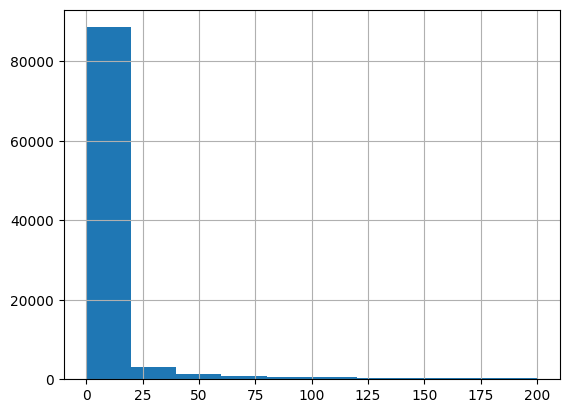

In [28]:
gap_data[gap_data < 200].hist()

только 5% возвращается спустя 2 месяца

In [29]:
gap_data.quantile(0.95)

59.760440972222156

90% возвращается спустя 18 дней, 10% более чем через 18 дней

In [30]:
gap_data.quantile(0.9)

18.325995370370403

## Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [31]:
#Если человек не получил сертификат и отсутствовал более 30 дней то он дропнувшийся

In [32]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [33]:
events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).head()

,user_id,timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [34]:
# максимальный таймстемп
30 * 24 * 60 * 60

2592000

In [35]:
events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).head()

,user_id,timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [36]:
users_data = events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [37]:
now = 1526772811
drop_out_treshold = 2592000

In [38]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [39]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [40]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [41]:
users_data.merge(users_scores).head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,2,1519226966,True,2,0
1,3,1444581588,True,29,23
2,5,1499859939,True,2,2
3,8,1481466913,True,9,21
4,14,1436368676,True,0,1


#### не все данные, т.к. по умолчанию учитывается только пересечение

In [42]:
users_data.merge(users_scores, how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [43]:
# по умолчанию merge ищет столбец с одинаковым названием
users_data.merge(users_scores, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [44]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [45]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [46]:
users_data = users_data.fillna(0)

In [47]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [48]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()


In [49]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [50]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

In [51]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [52]:
users_days = events_data.groupby('user_id').day.nunique()

In [53]:
users_days.head()

user_id
1    1
2    2
3    7
5    2
7    1
Name: day, dtype: int64

In [54]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [55]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [56]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [57]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


#### Проверяем не потеряли ли кого-нибудь?

In [58]:
users_data.user_id.nunique()

19234

In [59]:
events_data.user_id.nunique()

19234

#### Сколько человек прошло курс?

In [60]:
users_data['passed_course'] = users_data.passed > 170

In [61]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [62]:
# 100*1425/17809 - доля прошедших курс
users_data['passed_course'].value_counts(normalize=True)*100 # второй способ

passed_course
False    92.591245
True      7.408755
Name: proportion, dtype: float64